In [1]:
#load all packages
import tensorflow as tf
from tensorflow.keras import layers, models
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import recall_score, precision_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from keras import metrics
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
import cv2
import glob
from tensorflow.python.client import device_lib
from sklearn.multiclass import OneVsRestClassifier
from roc_multiclass import roc_multiclass
from precision_recall_multiclass import precision_recall_multiclass
from load_oasis_set import load_oasis_set
from DataGenerator import DataGenerator

keras.backend.clear_session()
from keras.models import Model, Sequential
from cnn_backbone import base_model

### Load Train Data and oversample

In [2]:
# load dataset from drive
PATH = "/Users/josealbertodiazsalas/Documents/Alzheimer_s Dataset/train"
IMAGE_SIZE = (208, 176)
train_ds = image_dataset_from_directory(
                                        PATH, 
                                        seed=10, 
                                        shuffle=False,              #<---
                                        image_size=IMAGE_SIZE, 
                                        batch_size=32
                                        )
                                        
# one hot encode the labels to fit into the cnn layers
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=3)))

Found 4053 files belonging to 3 classes.
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-06-13 16:01:34.956442: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-13 16:01:34.956540: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
# seperation of validation set
# !!! these sets are not shuffled !!!

train_big = train_ds
X1_train_big = []
y1_train_big = []
X2_train_big = []
y2_train_big = []
X3_train_big = []
y3_train_big = []


for img, label in train_ds.unbatch():
    if label.numpy()[0] == 1:
        X1_train_big.append(img.numpy())
        y1_train_big.append(label.numpy())

    if label.numpy()[1] == 1:
        X2_train_big.append(img.numpy())
        y2_train_big.append(label.numpy())

    if label.numpy()[2] == 1:
        X3_train_big.append(img.numpy())
        y3_train_big.append(label.numpy())

2022-06-13 16:01:35.023642: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [4]:
# create dataset for class 1 -NO oversampling- (healthy)
X1_train_big = np.array(X1_train_big)
y1_train_big = np.array(y1_train_big)

In [5]:
# oversampling for class 2 (very mild)

randomPicksIdx = [np.random.choice(len(X2_train_big)) for i in range(len(X1_train_big) - len(X2_train_big))]

for i in randomPicksIdx:
    X2_train_big.append(X2_train_big[i])
    y2_train_big.append(y2_train_big[i])

X2_train_big = np.array(X2_train_big)
y2_train_big = np.array(y2_train_big)

In [6]:
# oversampling for class 3 (mild)
randomPicksIdx = [np.random.choice(len(X3_train_big)) for i in range(len(X1_train_big) - len(X3_train_big))]

for i in randomPicksIdx:
    X3_train_big.append(X3_train_big[i])
    y3_train_big.append(y3_train_big[i])

X3_train_big = np.array(X3_train_big)
y3_train_big = np.array(y3_train_big)

In [7]:
# combine all data sets
X_train_fullset = np.concatenate((X1_train_big,X2_train_big,X3_train_big), axis=0)
y_train_fullset = np.concatenate((y1_train_big,y2_train_big,y3_train_big), axis=0)

In [8]:
# shuffle the whole set
X_train_temp, y_train_temp = shuffle(X_train_fullset, y_train_fullset, random_state=10)

In [9]:
y_train_temp.shape

(6141, 3)

In [10]:
# finally create tensor dataset
data_generator = DataGenerator(X_train_temp, y_train_temp, batch_size = 32)

train_fullTensor = tf.data.Dataset.from_generator(
                                            data_generator,
                                            output_signature=(tf.TensorSpec(shape=(None, 208, 176, 3), dtype=tf.float32), tf.TensorSpec(shape=(None, 3), dtype=tf.float32))
                                            )

### Load Validation Set

In [11]:
# load validation dataset from drive
# set for training
PATH = "/Users/josealbertodiazsalas/Documents/Alzheimer_s Dataset/train"
IMAGE_SIZE = (208, 176)
val_ds = image_dataset_from_directory(
                                        PATH, 
                                        seed=10, 
                                        shuffle=True, 
                                        image_size=IMAGE_SIZE, 
                                        batch_size=32
                                        )

# one hot encode the labels to fit into the cnn layers
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, depth=3)))

Found 4053 files belonging to 3 classes.


/Users/josealbertodiazsalas/Desktop/neuefische/alzheimer-classification/.venv/lib/python3.9/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


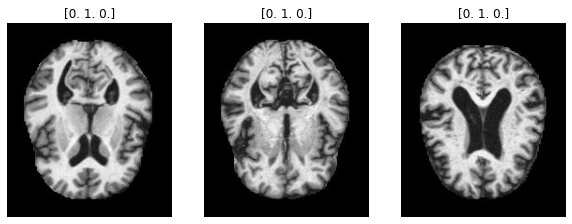

In [12]:
# # plot some example images from loaded set
plt.figure(figsize=(10, 10))
for images, labels in train_fullTensor.take(1):
  for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title([labels[i].numpy()][0])
    plt.axis("off")

In [27]:


with tf.device("/cpu:0"):
    data_augmentation = keras.Sequential([
        tf.keras.layers.Normalization(),
        layers.Resizing(208, 176),
        layers.RandomContrast(0.2),
        layers.RandomRotation(0.01),
        layers.RandomFlip(mode="horizontal"),    
        layers.RandomZoom(0.05),
        layers.RandomBrightness(0.2)
])

/Users/josealbertodiazsalas/Desktop/neuefische/alzheimer-classification/.venv/lib/python3.9/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


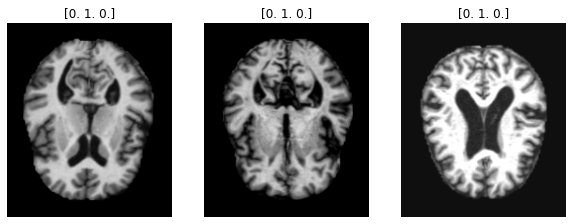

In [28]:
with tf.device("/cpu:0"):
    plt.figure(figsize=(10, 10))
    for images, labels in train_fullTensor.take(1):
        for i in range(3):
            ax = plt.subplot(1, 3, i + 1)
            img = data_augmentation(images)
            plt.imshow(img[i].numpy().astype("uint8"))
            plt.title([labels[i].numpy()][0])
            plt.axis("off")

------
## Build CNN model architecture

Following aspects to be considered:
- Weight from ImageNet-Dataset will be used within the pre-trained backbones
- All models will be trained in 30 epochs
- sss

### 1 - Model with VGG16 as backbone, trainable conv layers 

In [15]:
# Defining optimizer and learning rate
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.0001,
    decay_steps=train_fullTensor.cardinality().numpy()*100,
    decay_rate=1,
    staircase=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, name='Adam')

In [24]:
# Defining both base and final model architecture
b_model = base_model(MODEL='VGG16', freeze_layers=False)

In [23]:
b_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 208, 176, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 208, 176, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 208, 176, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 104, 88, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 104, 88, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 104, 88, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 52, 44, 128)       0     

In [29]:
# Definition conv and classification layers
model = models.Sequential()
model.add(data_augmentation)
model.add(b_model)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
#model.add(layers.Dropout(0.3))
model.add(layers.Dense(3, activation="softmax"))

# Print only Conv and Pooling layer from model architecture
model.build(input_shape=(208, 176, 3))
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 208, 176, 3)       7         
                                                                 
 vgg16 (Functional)          (None, 6, 5, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 15360)             0         
                                                                 
 dense_18 (Dense)            (None, 512)               7864832   
                                                                 
 dense_19 (Dense)            (None, 512)               262656    
                                                                 
 dense_20 (Dense)            (None, 3)                 1539      
                                                                 
Total params: 22,843,722
Trainable params: 22,843,715


In [ ]:
# Freeze the the behavior of that model. If any trainable value changes, compile() must be called again
keras.backend.clear_session()
model.compile(optimizer=optimizer,
    loss="CategoricalCrossentropy",
    metrics=[metrics.Precision(), metrics.Recall(), metrics.AUC()])

In [ ]:
# Saving model parameters and weights per epoch
checkpoint_filepath = '/Users/josealbertodiazsalas/Documents/CNN_transferlearning_models/checkpoint_model.epoch{epoch:02d}-recall{val_recall:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_recall', mode='max',
save_best_only=True)

# Model training. Model weights are saved at the end of every epoch, if it's the best seen so far
with tf.device("/gpu:0"):
    tf.random.set_seed(10)
    model_history = model.fit(x=train_ds,
                        validation_data=val_ds,
                        epochs=30, 
                        shuffle=True,
                        callbacks=[model_checkpoint_callback]
                        )

In [ ]:
model.save('/Users/josealbertodiazsalas/Documents/CNN_transferlearning_models/model.h5')

### 2 - CNN Model with XXX as backbone, trainable conv layers

### 3 - CNN Model with XXX as backbone, no trainable conv layers

### 4 - CNN Model with XXX as backbone, trainable conv layers